# Classification in Qiskit

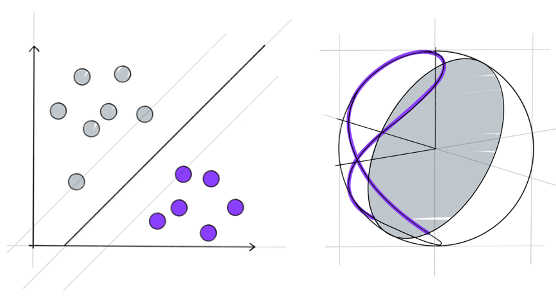

annaphan@au.ibm.com <br>_4 December 2020_

In [1]:
# This notebook can be presented as a deck by uncommenting and running:
#!jupyter nbconvert ./qiskit_intro.ipynb --to slides --post serve

# Or by installing RISE: https://damianavila.github.io/RISE/ and using CTRL-R

# Contents


1. [Data](#Data)
    1. [Preprocessing](#Data-Preprocessing)
    2. [Encoding](#Data-Encoding)
2. [Classification](#Classification)
    1. [Variational Quantum Classifier](#Variational-Quantum-Classifier)
    2. [Quantum Kernel Estimator](#Quantum-Kernel-Estimator)
        1. [qiskit](#qiskit)
        2. [scikit-learn](#scikit-learn)

In [2]:
# General Imports
import time
import numpy as np
from functools import reduce

# Visualisation Imports
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit Imports
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer

# Aqua Imports
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.optimizers import SPSA

import qiskit.aqua.operators as aquaop

# Circuit Imports
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate

# Algorithm Imports
from qiskit.aqua.algorithms.classifiers import VQC, QSVM

# Data

The data we are going to work with today will be a small subset of the well known handwritten [digits dataset](https://scikit-learn.org/stable/datasets/index.html#digits-dataset), which is available through scikit-learn. We will be aiming to differentiate between '0' and '1'. 

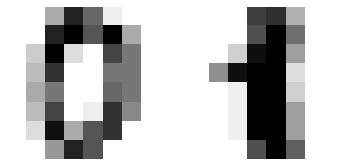

In [3]:
# Load digits dataset
digits = datasets.load_digits(n_class=2)

# Plot example '0' and '1'
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

## Data Preprocessing

There are a total of 360 datapoints in the dataset. Each datapoint is a 8x8 image of a digit, collapsed into an array, where each element is an integer between 0 (white) and 16 (black). As per classical classification, we need to split the dataset into training (100) and testing (20) samples, and normalise it. To use the dataset for quantum classification, we need to scale the range to between -1 and 1, and reduce the dimensionality to the number of qubits we want to use (4).

Note that in Qiskit, this is done for this dataset in `qiskit.ml.datasets.digits`, but it is made explicit in this lecture for future reference. 

In [4]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

# Reduce dimensions
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

To use the qiskit `VQC` and `QSVM` algorithms, the training and testing data need to be in a particular format, a dictionary where the keys are the class labels and the values are arrays of datapoints for those labels. 

In [5]:
class_labels = np.unique(label_train)

train_data = {key: (sample_train[label_train == k, :]) 
                   for k, key in enumerate(class_labels)}
test_data = {key: (sample_test[label_test == k, :]) 
                   for k, key in enumerate(class_labels)} 

## Data Encoding

The classification methods we will be using take the classical data and encode it to the quantum state space using a quantum feature map. The choice of which feature map to use is important and may depend on the given dataset we want to classify. Here we'll look at the feature maps available in qiskit, before selecting, and customising one to encode our data.

### Quantum Feature Maps

As the name suggests, a quantum feature map $\phi(\mathbf{x})$ is a map from the classical feature vector $\mathbf{x}$ to the quantum state $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$, a vector in Hilbert space. This is faciliated by applying the unitary operation $\mathcal{U}_{\Phi(\mathbf{x})}$ on the initial state $|0\rangle^{n}$ where _n_ is the number of qubits being used for encoding.

The feature maps currently available in qiskit ([`PauliFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html), [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html) and [`ZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)) are those introduced in [_Havlicek et al_.  Nature **567**, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2). These are conjectured to be hard to simulate classically and can be implemented as short-depth circuits on near-term quantum devices.

The `PauliFeatureMap` is defined as

```python
PauliFeatureMap(feature_dimension=None, reps=2, entanglement='full', paulis=None, data_map_func=None, parameter_prefix='x', insert_barriers=False)
```

and describes a the unitary operator of depth $d$:

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_i\right), $$

which contains layers of Hadamard gates interleaved with entangling blocks, $U_{\Phi(\mathbf{x})}$, encoding the classical data as shown in circuit diagram below for $d=2$.

<div>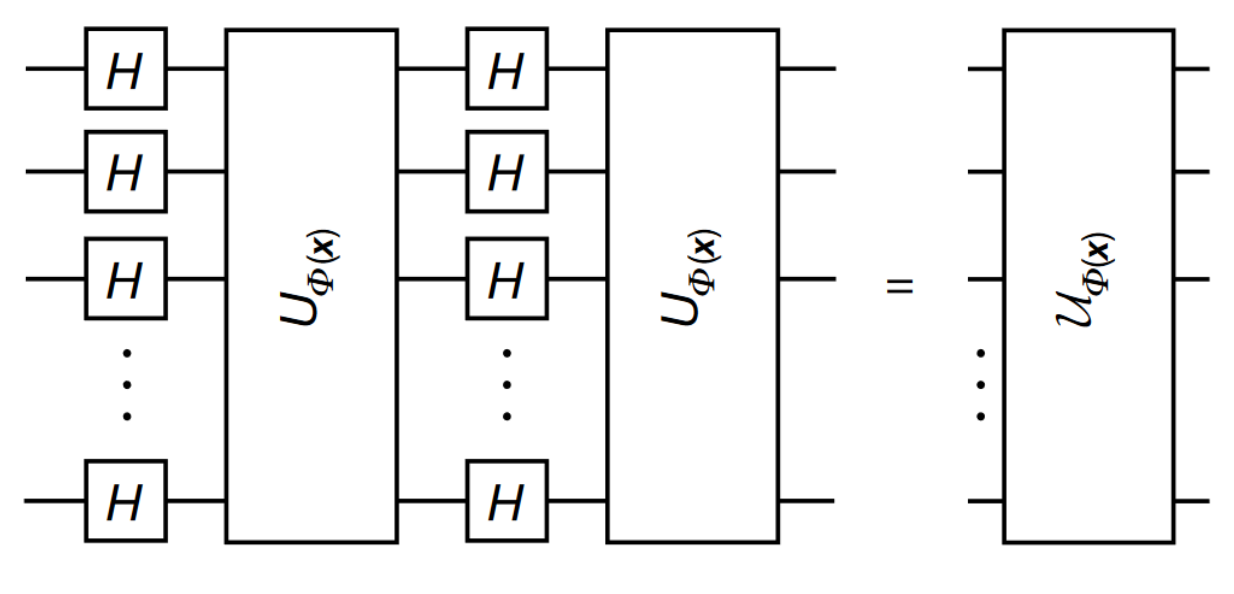</div>

Within the entangling blocks, $U_{\Phi(\mathbf{x})}$: $P_i \in \{ I, X, Y, Z \}$ denotes the Pauli matrices, the index $S$ describes connectivities between different qubits or datapoints: $S \in \{\binom{n}{k}\ combinations,\ k = 1,... n \}$, and by default the data mapping function $\phi_S(\mathbf{x})$ is 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

when $k = 1, P_0 = Z$, this is the `ZFeatureMap`: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$

which is defined as:
```python
ZFeatureMap(feature_dimension, reps=2, data_map_func=None, insert_barriers=False)
```

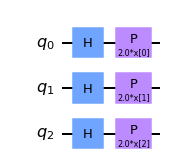

In [6]:
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=1)
map_z.draw('mpl')

note the lack of entanglement in this feature map.

and when $k = 2, P_0 = Z, P_1 = ZZ$, this is the `ZZFeatureMap`: 
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

which is defined as:
```python
ZZFeatureMap(feature_dimension, reps=2, entanglement='full', data_map_func=None, insert_barriers=False)
```

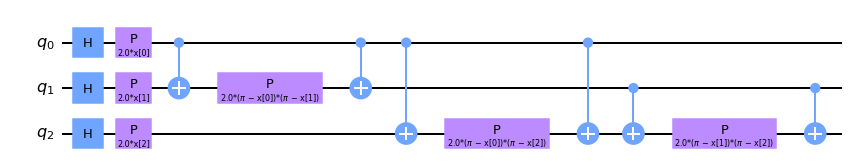

In [7]:
# 3 features, depth 1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.draw('mpl')

now that there is entanglement in the feature map, we can define the entanglement map:

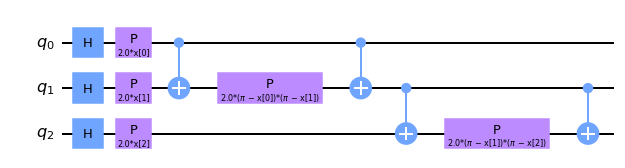

In [8]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.draw('mpl')

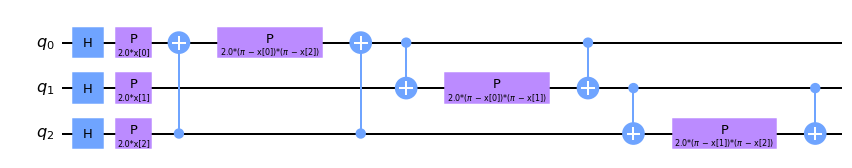

In [9]:
# 3 features, depth 1, circular entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.draw('mpl')

We can also customise the Pauli gates in the feature map, for example, $P_0 = X, P_1 = Y, P_2 = ZZ$:
$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, X_j\right) \, H^{\otimes n} \right)^d.$$ 

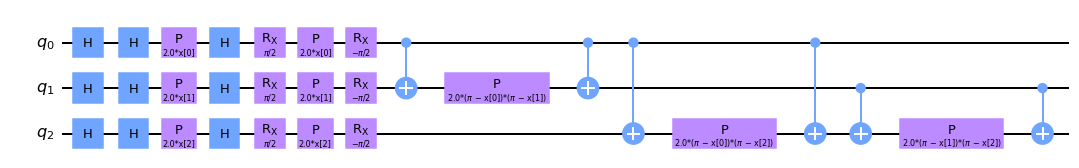

In [10]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'],)
map_pauli.draw('mpl')

We can also define a custom data mapping function, for example: 
$$\phi_S:\mathbf{x}\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        \sin(\pi-x_i)\sin(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$

In [11]:
def custom_data_map_func(x):
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, np.sin(np.pi - x))
    return coeff

In [12]:
map_customdatamap = PauliFeatureMap(feature_dimension=3, reps=1, paulis=['Z','ZZ'],
                                    data_map_func=custom_data_map_func)

#map_customdatamap.draw() # qiskit isn't able to draw the circuit with np.sin in the custom data map 

The [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) and [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) functions in qiskit's circuit library can also be used to create parameterised quantum circuits as feature maps. 

```python
TwoLocal(num_qubits=None, rotation_blocks=None, entanglement_blocks=None, entanglement='full', reps=3, skip_unentangled_qubits=False, skip_final_rotation_layer=False, parameter_prefix='θ', insert_barriers=False, initial_state=None)
```

```python
NLocal(num_qubits=None, rotation_blocks=None, entanglement_blocks=None, entanglement=None, reps=1, insert_barriers=False, parameter_prefix='θ', overwrite_block_parameters=True, skip_final_rotation_layer=False, skip_unentangled_qubits=False, initial_state=None, name='nlocal')
```

Both functions create parameterised circuits of alternating rotation and entanglement layers. In both layers, parameterised circuit-blocks act on the circuit in a defined way. In the rotation layer, the blocks are applied stacked on top of each other, while in the entanglement layer according to the entanglement strategy. Each layer is repeated a number of times, and by default a final rotation layer is appended.

In `NLocal`, the circuit blocks can have arbitrary sizes (smaller equal to the number of qubits in the circuit), while in `TwoLocal`, the rotation layers are single qubit gates applied on all qubits and the entanglement layer uses two-qubit gates.

For example, here is a `TwoLocal` circuit, with $R_y$ and $R_x$ gates in the rotation layer and $CX$ gates in the entangling layer with circular entanglement:

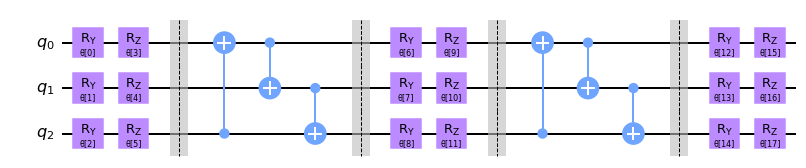

In [13]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.draw('mpl')

and the equivalent `NLocal` circuit:

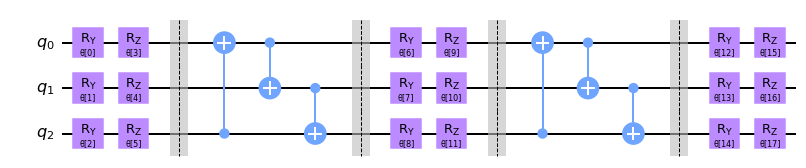

In [14]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.draw('mpl')

Here is another `NLocal` circuit, with a rotation block on 2 qubits and an entanglement block on 4 qubits using linear entanglement:

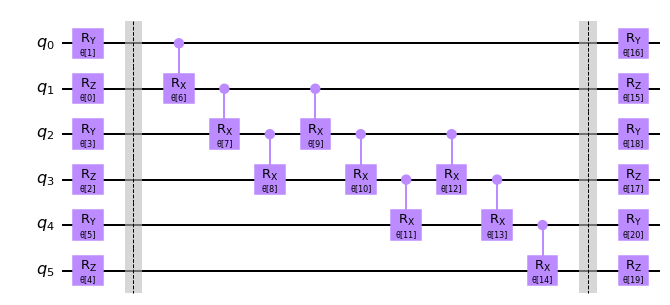

In [15]:
# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4) 
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

nlocal = NLocal(num_qubits=6, 
                rotation_blocks=rot, entanglement_blocks=ent, 
                entanglement='linear', insert_barriers=True)
nlocal.draw('mpl')

It is also possible to create a completely custom parameterised circuit feature map. To do so, simply create a `QuantumCircuit` with a [`ParameterVector`](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html). Here's an example:

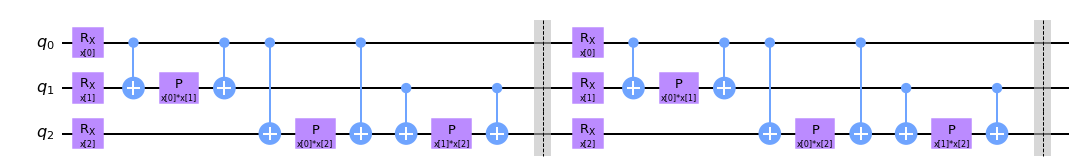

In [16]:
qubits = 3     
repeats = 2

x = ParameterVector('x', length=qubits)
var_custom = QuantumCircuit(qubits)

for _ in range(repeats):
    for i in range(qubits):
        var_custom.rx(x[i], i)
    for i in range(qubits):
        for j in range(i + 1, qubits):
            var_custom.cx(i, j)
            var_custom.p(x[i] * x[j], j)
            var_custom.cx(i, j)
    var_custom.barrier()
            
var_custom.draw('mpl')

# Classification

We will now classify the data using the two methods currently available in qiskit (version 0.23.0): the variational quantum classifier and the quantum kernel estimator. 

## Variational Quantum Classifier

The variational quantum classifier consists of these steps:
1. Encoding the datapoint by applying a feature map, $\mathcal{U}_{\Phi(\vec{x})}$
2. Applying a variational circuit, $W(\vec{\theta})$
3. Measuring and determining which class the datapoint belongs to.

During the training phase, the parameters of the variational circuit $\vec{\theta}$ are determined through classical optimisation.

&nbsp;
<div>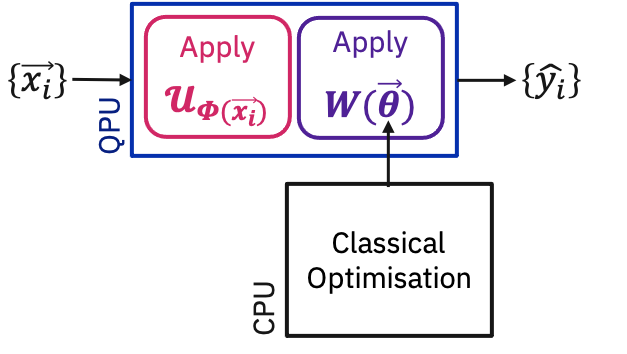</div>


### Variational Circuits

In the variational quantum classifier, a short depth variational circuit is appended to the previously constructed feature map. In the training phase of the algorithm, the parameters of this circuit are varied using classical optimisation until the selected 
cost function is minimised. New datapoints are then classified using the feature map and trained variational circuit.

The form of the varational circuit affects the accuracy and viability of the classifier. A short depth circuit will mean that it can be tested on current hardware, fewer parameters will decrease training time and the number of executed circuits, but for flexibility, it also needs to sample as much of the $n$ qubit Hilbert space as possible.

Building variational circuits with such conflicting requirements, similar to the study of quantum feature maps, is an active field of research.

In qiskit, the [circuit library](https://qiskit.org/documentation/apidoc/circuit_library.html) contains several circuits that can be used as variational forms, such as [`RealAmplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) or [`EfficientSU2`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html).

The `RealAmplitudes` circuit consists of of alternating layers of $Y$ rotations and $𝐶𝑋$ entanglements. It is called `RealAmplitudes` as the prepared quantum states will only have real amplitudes, the complex part is always 0.

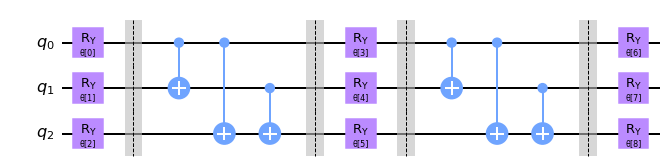

In [17]:
var_real = RealAmplitudes(num_qubits=3, reps=2, insert_barriers=True)
var_real.draw('mpl')

The `EfficientSU2` circuit consists of layers of single qubit operations spanned by $SU(2)$ and $𝐶𝑋$ entanglements. $SU(2)$ stands for special unitary group of degree 2, its elements are $2\times2$ unitary matrices with determinant 1, such as the Pauli rotation gates.

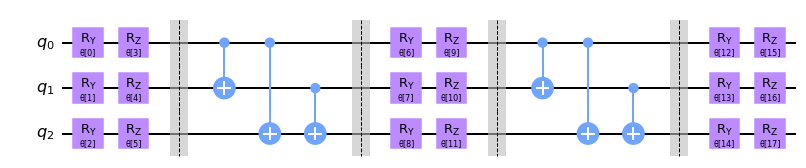

In [18]:
var_su2 = EfficientSU2(num_qubits=3, reps=2, insert_barriers=True)
var_su2.draw('mpl')

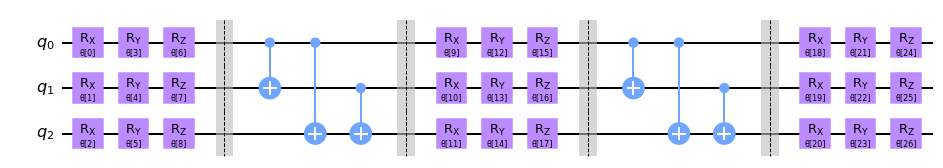

In [19]:
var_su2_gates = EfficientSU2(num_qubits=3, reps=2, su2_gates=['rx','ry','rz'], insert_barriers=True)
var_su2_gates.draw('mpl')

It is also possible to create a custom variational circuit, following the same logic as creating a custom feature map.

### Measurement and Assignment

After applying the feature map, variational form and measuring the circuit, we are left with an $n$ bit classical string $x_n = x_0 x_1 \ldots x_n$ from which we need to derive a binary output that will be our classification result $0$ or $1$. This is performed by a boolean function $f: \{0, 1\}^{n} -> \{0, 1\}$, and in the qiskit `VQC` algorithm , this is the *parity function*: $f(x) = x_0 \oplus x_1 \oplus \ldots \oplus x_n$, where $f(x) = 1$ if and only if the number of ones in $x_n$ is odd. 

### Cost and Optimisation

In the training phase, the parameters of the variational circuit $\vec{\theta}$ are determined through classical optimisation. In the qiskit `VQC` algorithm, the parameters are varied to minimise the cross entropy for the predicted and true assignments of the datapoints in the training sample.

There are many [optimisation](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html) algorithms to chose from, including:
- ADAM
- COBYLA - Constrained Optimization By Linear Approximation
- SPSA - Simultaneous Perturbation Stochastic Approximation

### Implementation

The [`VQC`](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQC.html) algorithm within qiskit implements all the required code, only the feature map, variational form, optimiser need to be specified, along with the training and test data. 

In [20]:
# feature map
feature_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear')

# variational form
var_form = EfficientSU2(n_dim, reps=2)

# optimiser
optimizer = SPSA()

# quantum instance
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend)

A callback function can also be constructed to store the parameter values and cost after each optimisation iteration during the training phase.

In [21]:
parameters = {}
cost = {}

def callback_vqc(eval_count, var_params, eval_val, index):
    parameters[eval_count] = var_params
    cost[eval_count] = eval_val

In [22]:
vqc = VQC(optimizer=optimizer, 
          feature_map=feature_map, 
          var_form=var_form, 
          callback=callback_vqc, 
          training_dataset=train_data, 
          test_dataset=test_data)

In [23]:
qvc_result = vqc.run(quantum_instance)

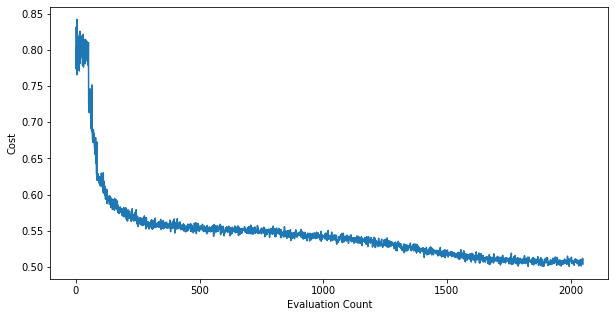

In [24]:
# plot cost optimisation
plt.figure(figsize=(10,5))
plt.plot(cost.keys(),cost.values())
plt.xlabel('Evaluation Count')
plt.ylabel('Cost')
plt.show()

In [25]:
# final cost and parameters
print("final cost:")
print(np.round(cost[list(cost)[-1]],4))

print("final parameters:")
print(np.round(parameters[list(parameters)[-1]],2))

final cost:
0.5044
final parameters:
[-2.71 -0.93 -1.23  0.66 -0.99  2.75  0.03 -1.02  0.03  1.56  0.05  1.22
 -0.03  0.2  -0.55  1.1  -1.46 -3.39 -2.07 -2.52 -0.16  0.7   2.22 -0.83]


In [26]:
print(qvc_result['testing_accuracy'])

0.8


## Quantum Kernel Estimator

The quantum kernel estimator consists of these steps:

1. Build the train and test quantum kernel matrices.
    1. For each pair of datapoints in the training dataset $\vec{x}_{i},\vec{x}_j$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathcal{U}^\dagger_{\Phi(\vec{x_j})} \mathcal{U}_{\Phi(\vec{x_i})} | 0 \rangle \right|^2 $. This should be a positive semi-definite matrix.  
    2. For each training datapoint $\vec{x_i}$ and testing point $\vec{y_i}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathcal{U}^\dagger_{\Phi(\vec{y_i})} \mathcal{U}_{\Phi(\vec{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

<div>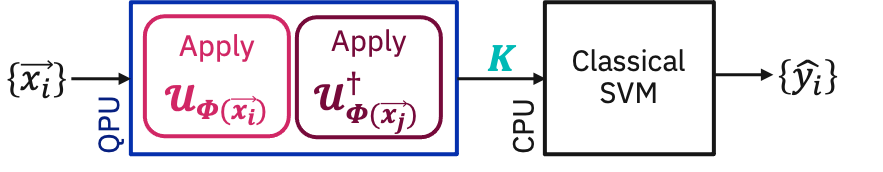</div>



### qiskit

The [`QSVM`](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.QSVM.html) algorithm within qiskit implements both the quantum kernel calculation and the classical support vector classification.

In [27]:
qsvm = QSVM(feature_map=feature_map, 
            training_dataset=train_data, 
            test_dataset=test_data)

In [28]:
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backend)
result = qsvm.run(quantum_instance)

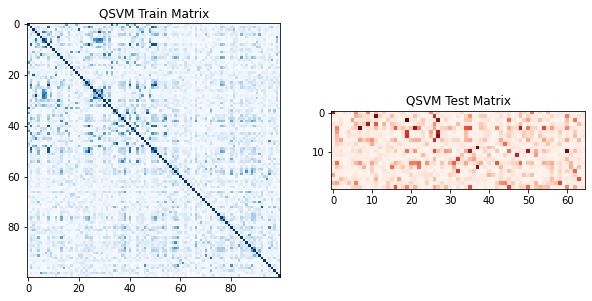

In [29]:
# plot matrices
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(result['kernel_matrix_training']),interpolation='nearest',origin='upper',cmap='Blues')
axs[0].set_title("QSVM Train Matrix")
axs[1].imshow(np.asmatrix(result['kernel_matrix_testing']),interpolation='nearest',origin='upper',cmap='Reds')
axs[1].set_title("QSVM Test Matrix")
plt.show()

In [30]:
print(result['testing_accuracy'])

1.0


### scikit-learn

It is also possible to use the qiskit `QSVM` algorithm to calculate the quantum kernel matrices and use them in the [`scikit-learn` support vector classifier algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [31]:
# train matrix
qk_train = QSVM.get_kernel_matrix(quantum_instance=quantum_instance,
                                  feature_map=feature_map,
                                  x1_vec= sample_train)

# test matrix
qk_test = QSVM.get_kernel_matrix(quantum_instance=quantum_instance,
                                 feature_map=feature_map,
                                 x1_vec= sample_test,
                                 x2_vec= sample_train)

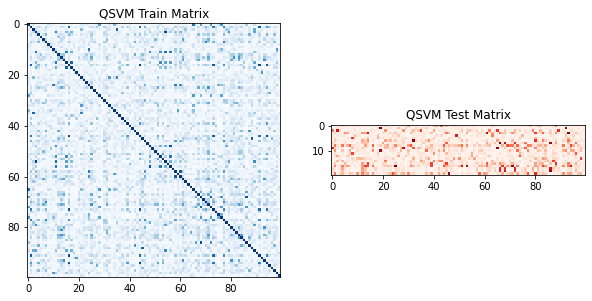

In [32]:
# plot matrices
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(qk_train),interpolation='nearest',origin='upper',cmap='Blues')
axs[0].set_title("QSVM Train Matrix")
axs[1].imshow(np.asmatrix(qk_test),interpolation='nearest',origin='upper',cmap='Reds')
axs[1].set_title("QSVM Test Matrix")
plt.show()

In [33]:
# train scikit-learn svm model
model = SVC(kernel='precomputed')
model.fit(qk_train, label_train)

# test svm model
model.score(qk_test, label_test)

0.95

We can also calculate the quantum kernel matrices using qiskit operators.

In [34]:
train_circs = aquaop.CircuitStateFn(feature_map).bind_parameters({param:vals for (param, vals) in zip(feature_map.parameters, np.transpose(sample_train).tolist())})
test_circs = aquaop.CircuitStateFn(feature_map).bind_parameters({param:vals for (param, vals) in zip(feature_map.parameters, np.transpose(sample_test).tolist())})

In [35]:
# analytical train matrix
qk_train = np.abs((~train_circs.to_matrix_op() @ train_circs.to_matrix_op()).eval())**2

In [36]:
# analytical test matrix
qk_test = np.abs((~test_circs.to_matrix_op() @ train_circs.to_matrix_op()).eval())**2

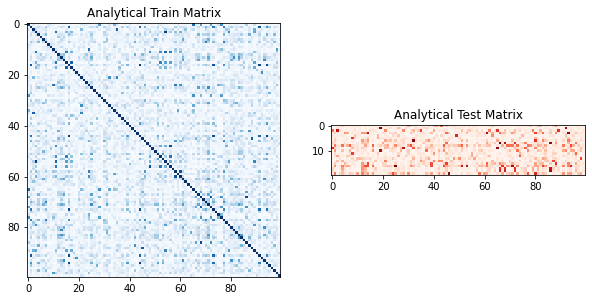

In [37]:
# plot analytical matrices
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(qk_train),interpolation='nearest',origin='upper',cmap='Blues')
axs[0].set_title("Analytical Train Matrix")
axs[1].imshow(np.asmatrix(qk_test),interpolation='nearest',origin='upper',cmap='Reds')
axs[1].set_title("Analytical Test Matrix")
plt.show()

In [38]:
circuit_sim = aquaop.CircuitSampler(quantum_instance)

In [39]:
# simulated train matrix (symmetric)

# triangle including diagonal
qk_train_tri = aquaop.ListOp([~train_circ @ (aquaop.ListOp(train_circs[0:i+1])) for (i, train_circ) in enumerate(train_circs)])

# simulate triangle
qk_train_tri_sim = circuit_sim.convert(qk_train_tri)
qk_train_tri_sim_results = qk_train_tri_sim.eval()
qk_train_tri_sim_results[0] = [qk_train_tri_sim_results[0]] # hack around qiskit bug

# build up full kernel matrix
qk_train_sim_size = np.array([i+[0.0]*(len(train_circs)-len(i)) for i in qk_train_tri_sim_results])
qk_train_sim = qk_train_sim_size.T + qk_train_sim_size
np.fill_diagonal(qk_train_sim,np.diag(qk_train_sim_size))

In [40]:
# simulated test matrix (asymetric)
qk_test_sim_circ = circuit_sim.convert(~test_circs @ train_circs)
qk_test_sim = qk_test_sim_circ.eval()

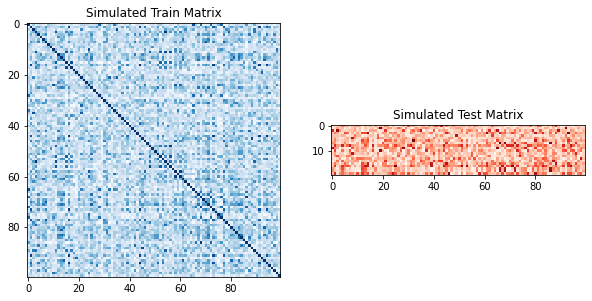

In [41]:
# plot simluated matrices
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(np.asmatrix(qk_train_sim),interpolation='nearest',origin='upper',cmap='Blues')
axs[0].set_title("Simulated Train Matrix")
axs[1].imshow(np.asmatrix(qk_test_sim),interpolation='nearest',origin='upper',cmap='Reds')
axs[1].set_title("Simulated Test Matrix")
plt.show()

In [42]:
# train scikit-learn svm model
model = SVC(kernel='precomputed')
model.fit(qk_train_sim, label_train)

# test svm model
model.score(qk_test_sim, label_test)

0.95

In [43]:
import qiskit.tools.jupyter
%qiskit_version_table